# DIFUSIÓN DEL CORONAVIRUS EN ESPAÑA:

## (5ª predicción) modelo SI

Vamos ahora a ajustar las ecuaciones del modelo SI:

$ dS/dt = -\beta \frac{IS}{N} $

$ dI/dt =  \beta \frac{IS}{N} $

De donde sale:

$ dS/dt + dI/dt = 0 $

$ S + I = cte. $

Entrando en la ecuación diferencial tendremos:

$ I' - \beta I = \beta \frac {I^2}{N} $

que es una ecuación de Bernoulli. Dividiendo ambos miembros por $ I^2 $ y haciendo el cambio: $ \sigma = 1/I $ tendremos:

$ \sigma' + \beta \sigma = \beta / N $

$ \sigma = A e^{ - \beta x} + 1/N $

Y por tanto:

$ I = \frac {1}{A e^{ - \beta x} + 1/N} $

e:

$ I' = \frac {A \beta e^{ - \beta x}}{(A e^{ - \beta x} + 1/N)^2} $

Probaremos a ajustar estas curvas, encontrando los valores adecuados para estos coeficientes empleando ajustes por mínimos cuadrados.

## 1) IMPORTACIÓN Y ARREGLO DE DATOS

In [1]:
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.optimize import leastsq

%matplotlib inline

In [2]:
plt.rcParams['figure.figsize'] = [18, 6]

In [3]:
ruta = 'Datos/Contagios medios coronavirus RTVE.csv'
sep = ';'

date_parser = lambda x: pd.datetime.strptime(x, '%d/%m/%Y')

datos = pd.read_csv(ruta, sep = sep, index_col = 'FECHA', parse_dates = ['FECHA'], date_parser = date_parser)
datos = datos.loc[:'2020-04-09', :]


datos['DIFER_DIAS'] = datos.index.to_series().diff().fillna(pd.Timedelta(seconds = 8660000)).apply(lambda x: x.days)

datos['CONT_DIARIOS'] = (datos['CONTAGIOS'].diff(1).fillna(0)/datos['DIFER_DIAS'])
datos['M_DIARIOS'] = (datos['MUERTOS'].diff(1).fillna(0)/datos['DIFER_DIAS'])

index_for_merge = pd.DataFrame(index = pd.date_range(datos.index[0], datos.index[-1]))

# Creamos un dataframe con todas las fechas para ambas series, y rellenamos los NaN con el último dato inmediatamente anterior:

datos_full_index = pd.merge(index_for_merge, datos, left_index= True, right_index= True, how='left')

datos_full_index[['CONT_DIARIOS', 'M_DIARIOS']] = datos_full_index[['CONT_DIARIOS', 'M_DIARIOS']].fillna(method = 'backfill')

datos_full_index['MARCA'] = datos_full_index['CONTAGIOS'].apply(lambda x: 0 if x > 0 else 1)

datos_full_index.loc[datos_full_index['MARCA'] == 1, ['CONT_DIARIOS', 'M_DIARIOS']] = datos_full_index.loc[datos_full_index['MARCA'] == 1, ['CONT_DIARIOS', 'M_DIARIOS']].cumsum()


datos_full_index[['CONTAGIOS','MUERTOS']] = datos_full_index[['CONTAGIOS','MUERTOS']].fillna(method = 'ffill')
datos_full_index.loc[datos_full_index['MARCA'] == 1, 'CONTAGIOS'] = datos_full_index.loc[datos_full_index['MARCA'] == 1, 'CONTAGIOS'] + datos_full_index.loc[datos_full_index['MARCA'] == 1, 'CONT_DIARIOS']
datos_full_index.loc[datos_full_index['MARCA'] == 1, 'MUERTOS'] = datos_full_index.loc[datos_full_index['MARCA'] == 1, 'MUERTOS'] + datos_full_index.loc[datos_full_index['MARCA'] == 1, 'M_DIARIOS']

datos_full_index['CONTAGIOS'] = datos_full_index['CONTAGIOS'].astype('int')
datos_full_index['MUERTOS'] = datos_full_index['MUERTOS'].astype('int')

In [4]:
contagios = pd.DataFrame(datos_full_index['CONTAGIOS'])
contagios['DIFER_DIAS'] = contagios.index.to_series().diff().fillna(pd.Timedelta(seconds = 8660000)).apply(lambda x: x.days)

muertos = pd.DataFrame(datos_full_index['MUERTOS'])
muertos['DIFER_DIAS'] = muertos.index.to_series().diff().fillna(pd.Timedelta(seconds = 8660000)).apply(lambda x: x.days)

In [5]:
contagios['DIFER'] = contagios['CONTAGIOS'].diff(1).fillna(0).astype('int')

contagios.drop(contagios.index[range(0,20)], inplace = True)

contagios['DIA'] = contagios['DIFER_DIAS'].cumsum()- contagios.loc[contagios.index[0], 'DIFER_DIAS']

In [6]:
muertos['DIFER'] = muertos['MUERTOS'].diff(1).fillna(0).astype('int')

muertos.drop(muertos[muertos['MUERTOS'] == 0].index, inplace = True)

muertos['DIA'] = muertos['DIFER_DIAS'].cumsum()- muertos.loc[muertos.index[0], 'DIFER_DIAS']

## 2) APLICACIÓN DE MODELO

## 2.1) CONTAGIOS

### Ajuste empleando serie de contagios totales

In [7]:
def error_mi_func(variab, x, y, weights):
    
    B, A0, alpha0, A1, alpha1 = variab
    
    y_est = B + A0 * x ** alpha0 + A1 * x **alpha1
    
    return weights * (y - y_est)

In [8]:
def error_mi_func_2(variab, x, y, weights):
    
    A0, beta0, K = variab
    
    y_est = 1/(A0 * np.exp(-beta0 * x) + K)
    
    return weights * (y - y_est)

In [9]:
weights = np.array(range(1, contagios.shape[0] + 1))

# weights = np.ones(contagios.shape[0])

# weights = contagios['CONTAGIOS']

vas = [1, 1, 1]

for i in range(1,5):
    sal = leastsq(error_mi_func_2, vas, args=(contagios['DIA'], contagios['CONTAGIOS'], weights))
    
    if sal[1] in range (1,5):
        break
    else:
        vas = sal[0]

coefs_i_1 = sal

In [10]:
x = contagios['DIA']

A0, beta0, K = sal[0]

contagios_totales = 1/(A0 * np.exp(-beta0 * x) + K)
contagios_diarios = (A0 * beta0 * np.exp (-beta0 * x))/(A0 * np.exp(-beta0 * x) + K) ** 2

contagios['PRED'] = contagios_totales.astype('int')
contagios['DIF_PRED'] = contagios['PRED'].diff().fillna(contagios.loc[contagios.index[0], 'DIFER']).astype('int')

contagios['DERIV'] =(contagios['PRED'].shift(-1) - contagios['PRED'].shift(1)) / 2
contagios['CHECK_DERIV'] = contagios_diarios

In [11]:
contagios['0'] = contagios_diarios
contagios['+1'] = contagios['0'].shift(1).fillna(contagios['DIFER'])

contagios['PRED_DIARIOS'] = ((contagios['0'] + contagios['+1'] ) / 2).round()

contagios.drop(['0', '+1'], axis = 1, inplace = True)

In [12]:
diferencia = contagios.loc[contagios.index[0], 'PRED'] - contagios.loc[contagios.index[0], 'PRED_DIARIOS']

contagios['PRED_DIARIOS_CUMSUM'] = contagios['PRED_DIARIOS'].cumsum() + diferencia

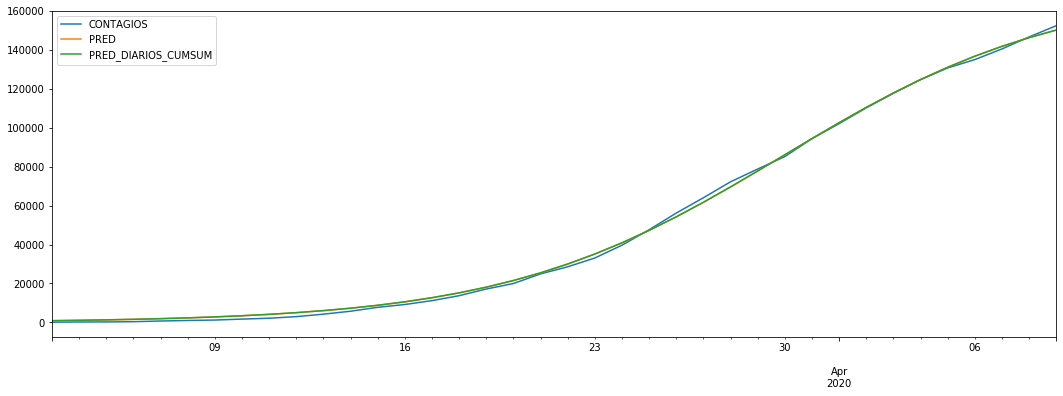

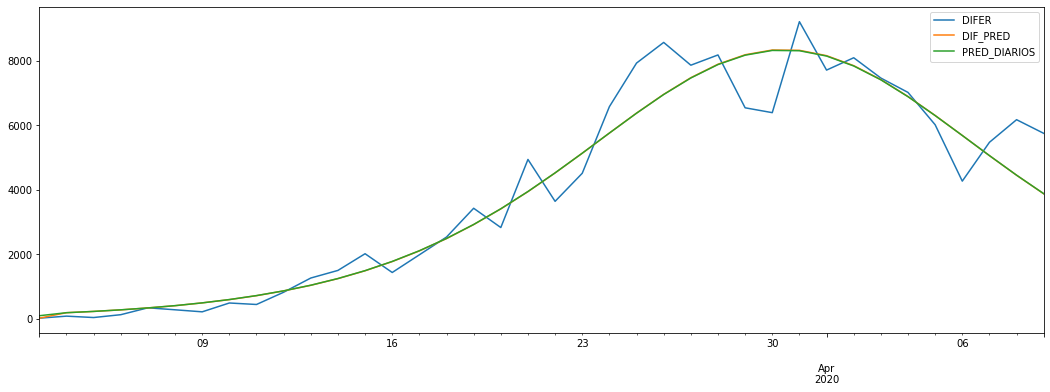

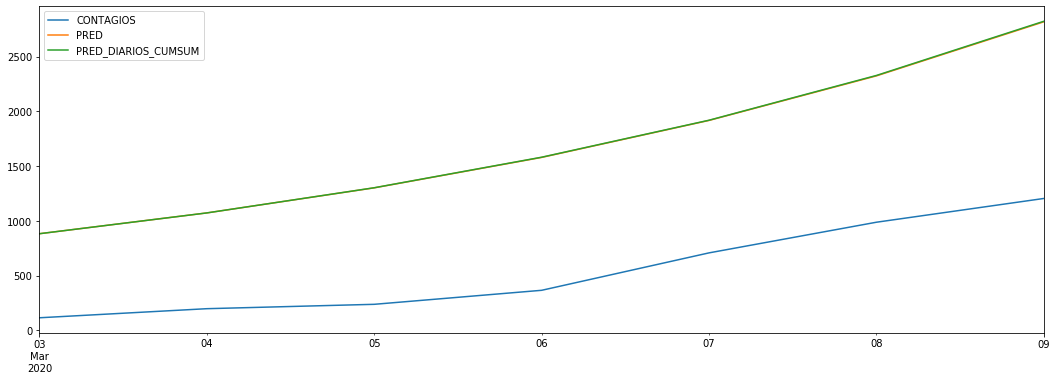

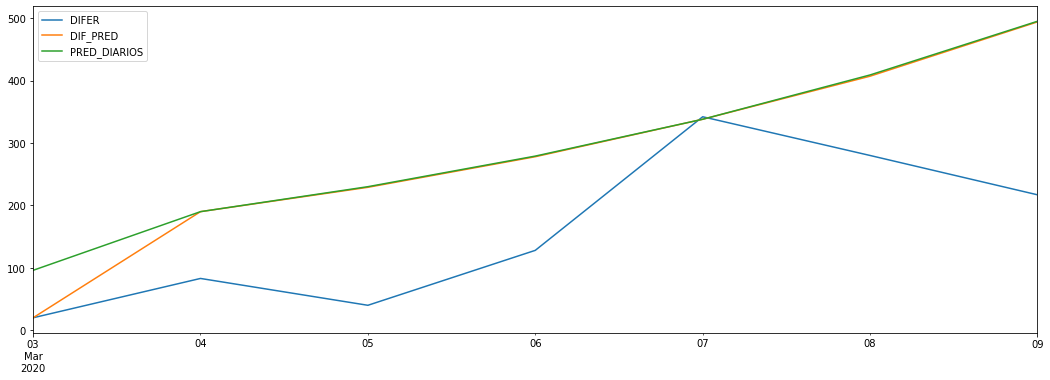

In [13]:
lista1 = ['CONTAGIOS','PRED', 'PRED_DIARIOS_CUMSUM']
lista2 = ['DIFER', 'DIF_PRED', 'PRED_DIARIOS']

contagios[lista1].plot()
contagios[lista2].plot()

contagios.loc[contagios.index[0:7], lista1].plot()
contagios.loc[contagios.index[0:7],lista2].plot()

In [14]:
end_day = contagios['DIA'][-1]
end_date = contagios.index[-1]

index = [end_date + datetime.timedelta(x) for x in range(1,6)]
days_for_pred = pd.Series(np.array(range(end_day + 1, end_day + 6)), index = index)

In [15]:
ajuste = contagios['CONTAGIOS'] - contagios['PRED']

pred_0 = 1/(A0 * np.exp(-beta0 * days_for_pred) + K)
# pred_0 = pred_0 + ajuste[-1]

dif_0 = pred_0[0] -contagios.loc[contagios.index[-1], 'PRED'] 
pred_0_diarios = pred_0.diff().fillna(dif_0).astype(int)

pred_0 = pred_0.astype('int')

In [16]:
pred_0_diarios

2020-04-10    3349
2020-04-11    2869
2020-04-12    2441
2020-04-13    2066
2020-04-14    1740
dtype: int32

In [17]:
days_for_pred_2 = pd.Series(np.array(range(end_day, end_day + 6)))

aux_1 = ((A0 * beta0 * np.exp (-beta0 * days_for_pred_2))/(A0 * np.exp(-beta0 * days_for_pred_2) + K) ** 2).astype('int')
pred_1 = (aux_1 + aux_1.shift(1))/2
pred_1 = pred_1[1:].astype(int)
pred_1.index = pred_0.index
pred_1

2020-04-10    3353
2020-04-11    2873
2020-04-12    2445
2020-04-13    2070
2020-04-14    1743
dtype: int32

### Ajuste empleando valores diarios

In [18]:
contagios2 = contagios[['CONTAGIOS', 'DIFER', 'DIA']].copy()

In [19]:
def rolling_average(series: pd.Series, periods: int, centered: bool):
    
    rolling = series.rolling(window = 3, center = True).mean()
    rolling[rolling.isna()] = series
    rolling = rolling * (series.sum()/rolling.sum())
    
    return rolling

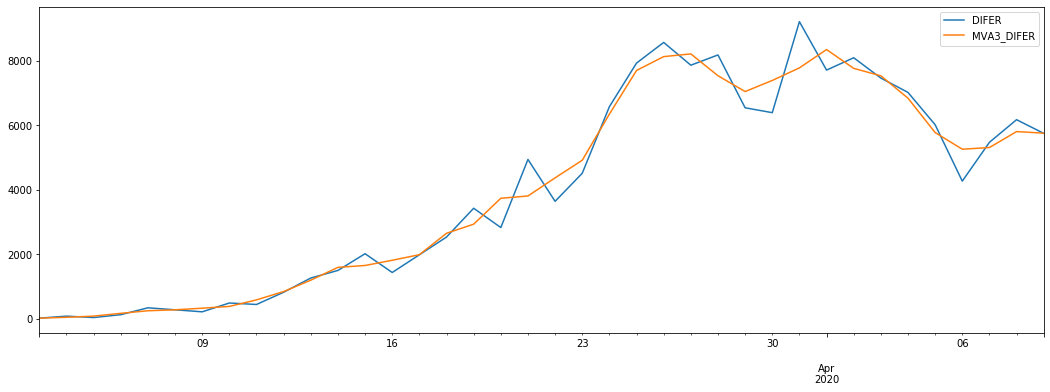

In [20]:
contagios2['MVA3_DIFER'] = rolling_average(contagios2['DIFER'], 3, True)
contagios2[['DIFER','MVA3_DIFER']].plot()

In [21]:
def error_mi_func_3(variab, x, y, weights):
    
    A0, beta0, K = variab
    
    y_est = (A0 * beta0 * np.exp (-beta0 * x))/(A0 * np.exp(-beta0 * x) + K) ** 2
    
    return weights * (y - y_est)

In [22]:
weights = np.ones(contagios2.shape[0])

# weights = list(range(1, contagios2.shape[0] + 1))

vas = [0.05, 0.01, 0.02]

for i in range(1,5):
    sal = leastsq(error_mi_func_3, vas, args=(contagios2['DIA'], contagios2['MVA3_DIFER'], weights))
    
    if sal[1] in range (1,5):
        break
    else:
        vas = sal[0]

coefs_i_2 = sal

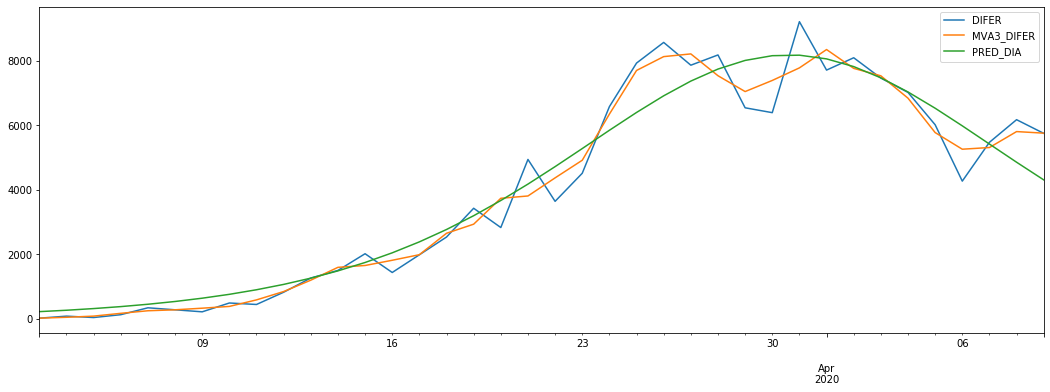

In [23]:
x = contagios2['DIA']

A0, beta0, K = sal[0]

contagios_totales = 1/(A0 * np.exp(-beta0 * x) + K)
contagios_diarios = (A0 * beta0 * np.exp (-beta0 * x))/(A0 * np.exp(-beta0 * x) + K) ** 2

contagios2['PRED_TOT'] = contagios_totales.astype('int')
contagios2['PRED_DIA'] = contagios_diarios.astype('int')

# contagios['DERIV'] =(contagios['PRED'].shift(-1) - contagios['PRED'].shift(1)) / 2
# contagios['CHECK_DERIV'] = contagios_diarios
contagios2[['DIFER', 'MVA3_DIFER', 'PRED_DIA']].plot()

In [24]:
pred_2 = ((A0 * beta0 * np.exp (-beta0 * days_for_pred))/(A0 * np.exp(-beta0 * days_for_pred) + K) ** 2).astype(int)

In [25]:
pred_2

2020-04-10    3794
2020-04-11    3313
2020-04-12    2874
2020-04-13    2479
2020-04-14    2127
dtype: int32

In [26]:
predictions_cont = pd.DataFrame(zip(pred_1, pred_2), columns = ['pred_1', 'pred_2'], index = pred_1.index)

## 2.2) MUERTOS

### Ajuste empleando valores totales

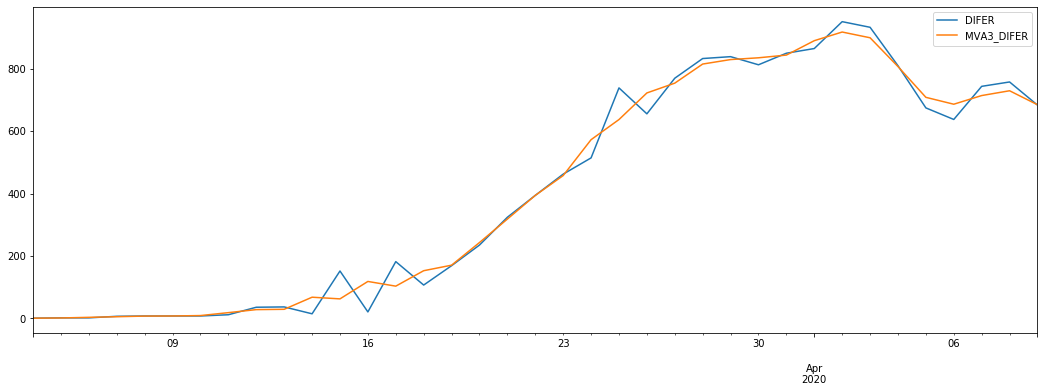

In [27]:
muertos['MVA3_DIFER'] = rolling_average(muertos['DIFER'], 3, True)
muertos[['DIFER','MVA3_DIFER']].plot()

In [28]:
weights = np.array(range(1, muertos.shape[0] + 1))
# weights = muertos['MUERTOS']

vas = [1, 1, 1]

for i in range(1,5):
    sal_2 = leastsq(error_mi_func_2, vas, args=(muertos['DIA'], muertos['MUERTOS'], weights))
    
    if sal[1] in range (1,5):
        break
    else:
        vas = sal_2[0]

coefs_m_1 = sal_2

In [29]:
x = muertos['DIA']

A0, beta0, K = sal_2[0]

muertos_totales = 1/(A0 * np.exp(-beta0 * x) + K)
muertos_diarios = (A0 * beta0 * np.exp (-beta0 * x))/(A0 * np.exp(-beta0 * x) + K) ** 2

muertos['PRED'] = muertos_totales.astype('int')
muertos['DIF_PRED'] = muertos['PRED'].diff().fillna(muertos.loc[muertos.index[0], 'DIFER']).astype('int')

muertos['DERIV'] = (muertos['PRED'].shift(-1) - muertos['PRED'].shift(1)) / 2
muertos['CHECK_DERIV'] = muertos_diarios

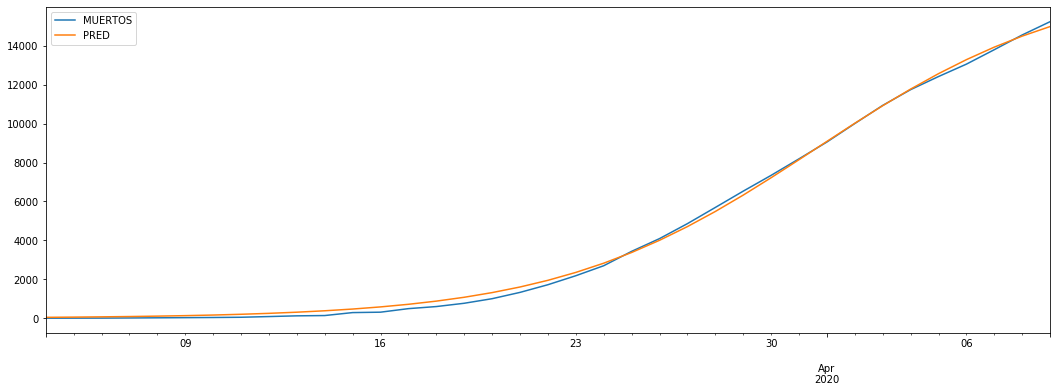

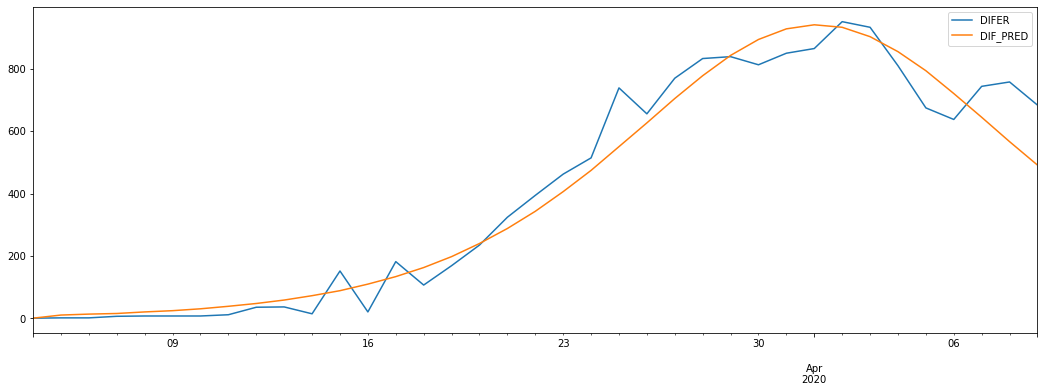

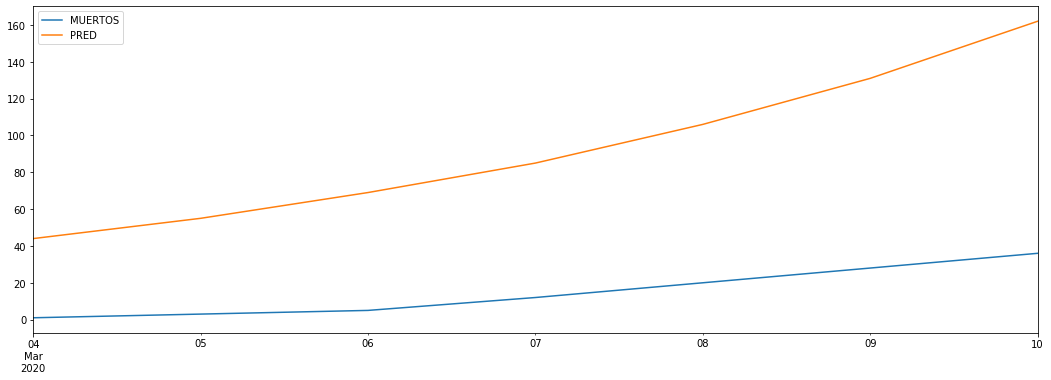

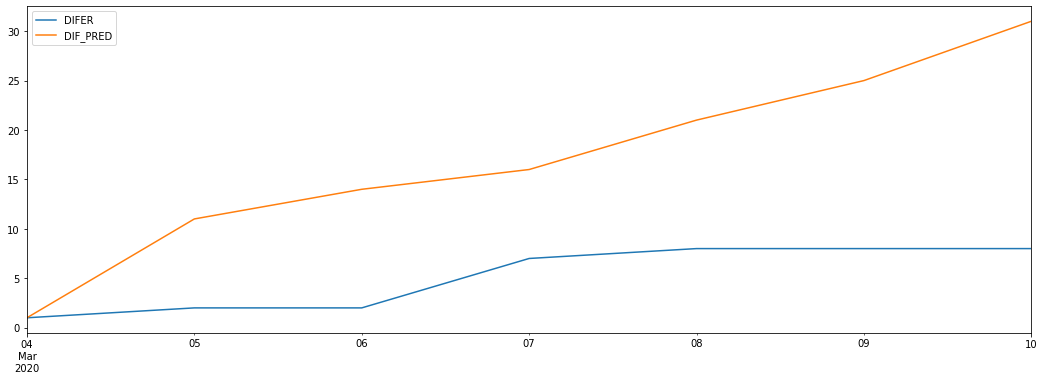

In [30]:
lista1 = ['MUERTOS','PRED']
lista2 = ['DIFER', 'DIF_PRED']

muertos[lista1].plot()
muertos[lista2].plot()

muertos.loc[muertos.index[0:7], lista1].plot()
muertos.loc[muertos.index[0:7],lista2].plot()

In [31]:
end_day = muertos['DIA'][-1]
end_date = muertos.index[-1]

index = [end_date + datetime.timedelta(x) for x in range(1,6)]
days_for_pred_2 = pd.Series(np.array(range(end_day + 1, end_day + 6)), index = index)

ajuste = muertos['MUERTOS'] - muertos['PRED']

pred_3 = 1/(A0 * np.exp(-beta0 * days_for_pred_2) + K)
# pred_0 = pred_0 + ajuste[-1]

dif_0 = pred_3[0] - muertos.loc[muertos.index[-1], 'PRED'] 
pred_3_diarios = pred_3.diff().fillna(dif_0).astype(int)

pred_3 = pred_3.astype('int')
pred_3_diarios

2020-04-10    421
2020-04-11    356
2020-04-12    299
2020-04-13    249
2020-04-14    206
dtype: int32

In [32]:
index = [end_date + datetime.timedelta(x) for x in range(0,6)]
days_for_pred_3 = pd.Series(np.array(range(end_day, end_day + 6)), index = index)

aux_1 = ((A0 * beta0 * np.exp (-beta0 * days_for_pred_3))/(A0 * np.exp(-beta0 * days_for_pred_3) + K) ** 2).astype('int')
pred_4 = (aux_1 + aux_1.shift(1))/2
pred_4 = pred_4[1:].astype(int)
pred_4

2020-04-10    420
2020-04-11    356
2020-04-12    299
2020-04-13    250
2020-04-14    207
dtype: int32

### Ajuste empleando valores diarios

In [33]:
muertos2 = muertos[['DIA', 'MUERTOS', 'DIFER', 'MVA3_DIFER']].copy()

In [34]:
weights = np.array(range(1, muertos2.shape[0] + 1))
# weights = muertos2['MUERTOS']

vas = [0.05, 0.05, 0.05]

for i in range(1,10):
    sal_3 = leastsq(error_mi_func_3, vas, args=(muertos2['DIA'], muertos2['MVA3_DIFER'], weights))
    
    if sal[1] in range (1,5):
        break
    else:
        vas = sal_3[0]

coefs_m_2 = sal_3

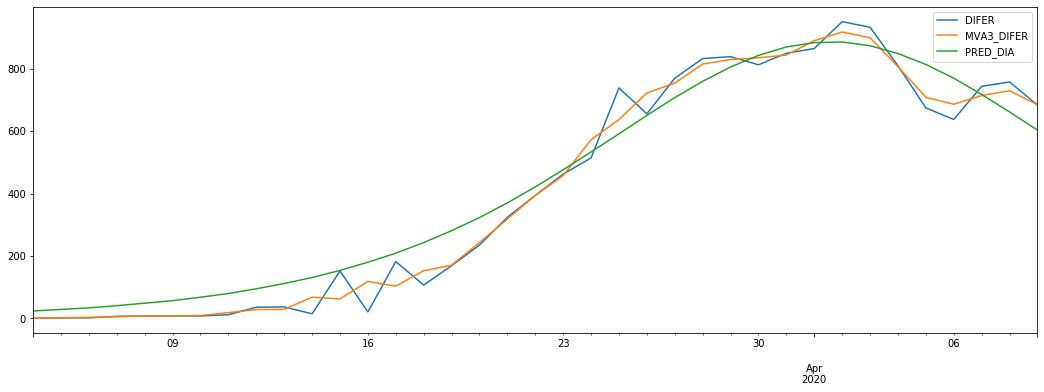

In [35]:
x = muertos2['DIA']

A0, beta0, K = sal_3[0]

muertos_totales = 1/(A0 * np.exp(-beta0 * x) + K)
muertos_diarios = (A0 * beta0 * np.exp (-beta0 * x))/(A0 * np.exp(-beta0 * x) + K) ** 2

muertos2['PRED_TOT'] = muertos_totales.astype('int')
muertos2['PRED_DIA'] = muertos_diarios.astype('int')

# contagios['DERIV'] =(contagios['PRED'].shift(-1) - contagios['PRED'].shift(1)) / 2
# contagios['CHECK_DERIV'] = contagios_diarios
muertos2[['DIFER', 'MVA3_DIFER', 'PRED_DIA']].plot()

In [36]:
muertos2['PRED_DIA_CUMSUM'] = muertos2['PRED_DIA'].cumsum()

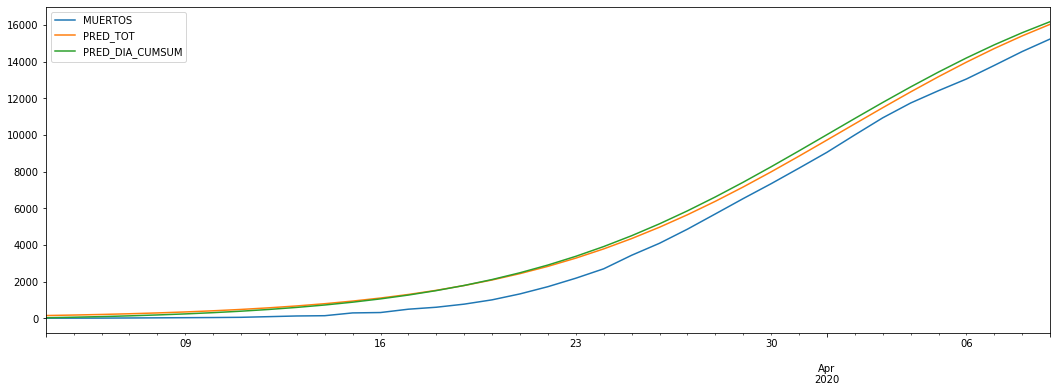

In [37]:
muertos2[['MUERTOS', 'PRED_TOT', 'PRED_DIA_CUMSUM']].plot()

In [38]:
pred_5 = (A0 * beta0 * np.exp (-beta0 * days_for_pred_2))/(A0 * np.exp(-beta0 * days_for_pred_2) + K) ** 2
pred_5 = pred_5.astype(int)

In [39]:
predictions_m = pd.DataFrame(zip(pred_3_diarios, pred_4, pred_5), columns = ['pred_3', 'pred_4', 'pred_5'], index = pred_3_diarios.index)

## 3) PREDICCIONES

In [40]:
predictions_cont

,pred_1,pred_2
2020-04-10,3353,3794
2020-04-11,2873,3313
2020-04-12,2445,2874
2020-04-13,2070,2479
2020-04-14,1743,2127


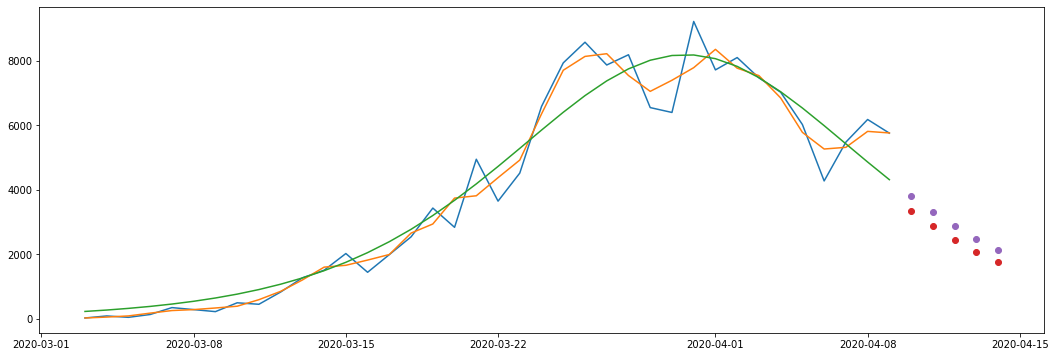

In [41]:
plt.plot(contagios2[['DIFER', 'MVA3_DIFER', 'PRED_DIA']])
plt.plot(predictions_cont, 'o')

In [42]:
predictions_m

,pred_3,pred_4,pred_5
2020-04-10,421,420,544
2020-04-11,356,356,487
2020-04-12,299,299,432
2020-04-13,249,250,380
2020-04-14,206,207,332


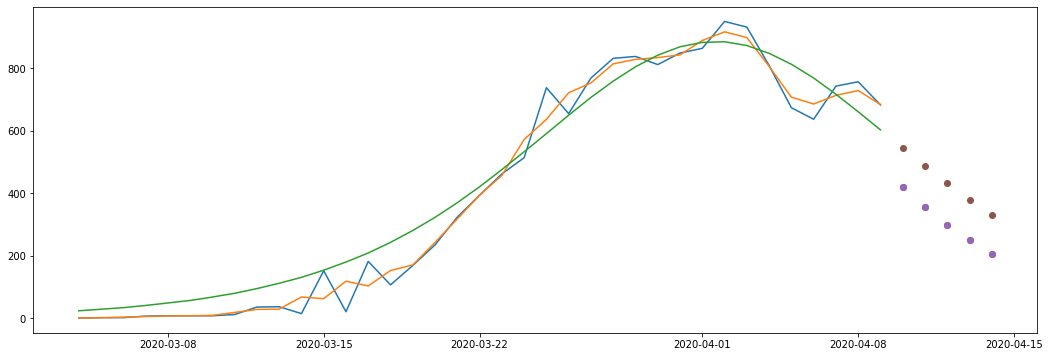

In [43]:
plt.plot(muertos2[['DIFER', 'MVA3_DIFER', 'PRED_DIA']])
plt.plot(predictions_m, 'o')

## 4) ANÁLISIS DE COEFICIENTES

Imprimos los coeficientes obtenidos para los distintos modelos:

In [44]:
print(coefs_i_1)
print(coefs_i_2)
print(coefs_m_1)
print(coefs_m_2)

(array([1.12676602e-03, 1.95344606e-01, 5.83873224e-06]), 1)
(array([7.96084095e-04, 1.80122864e-01, 5.49663341e-06]), 1)
(array([2.22125322e-02, 2.15835741e-01, 5.73438788e-05]), 1)
(array([6.84231795e-03, 1.72872402e-01, 4.87716881e-05]), 1)


Podemos ver la gran similaridad entre los coeficientes de los dos modelos que predicen la cantidad de infectados, y la existente entre los dos modelos que predicen la cantidad de defunciones.

Es una señal de congruencia en los resultados obtenidos por cada vía.

In [45]:
A_1, beta_1, K_1 = coefs_i_1[0]
A_2, beta_2, K_2 = coefs_i_2[0]
A_10, beta_10, K_10 = coefs_m_1[0]
A_11, beta_11, K_11 = coefs_m_2[0]

In [46]:
beta_1, beta_2

(0.19534460590256392, 0.18012286431101565)

In [47]:
np.exp(beta_1), np.exp(beta_2)

(1.215729861998467, 1.1973644674450168)

Como podemos ver, el coeficiente de propagación del virus nos indica que el número de infectados aumenta un 20% cada día.

In [48]:
print(1/K_1)
print(1/K_2)

171270.05652325778
181929.54222536288


El virus parece propagarse (al menos con los resultados oficiales) como si hubiese "visto" una población de unos 170.000 - 180.000 habitantes (en un país con una población de casi 47 millones).

Por supuesto, hay que tener en cuenta que los números de contagios reales no detectados son mucho mayores, pero aún así se puede apreciar el resultado del confinamiento:

In [49]:
print(1/K_10)
print(1/K_11)

17438.652913900787
20503.698749291765


El modelo, sin embargo, podemos ver que no es bueno en la estimación de la desescalada.

Al ser la ecuación de $I'$ simétrica, entiende que se produce una desescalada en los contagios simétrica respecto del pico, a la subida, cosa que podemos comprobar que no es cierta.

Vamos a estudiar por lo tanto con todas la componentes del modelo SIR entero, para ver cuál es su evolución real.